<a href="https://colab.research.google.com/github/xiaowshi/Long-Term_Reprojection_Loss/blob/master/Long_Term_Reprojection_Loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download Code:

In [2]:
!git clone https://github.com/xiaowshi/Long-Term_Reprojection_Loss.git

Cloning into 'Long-Term_Reprojection_Loss'...
remote: Enumerating objects: 412, done.
remote: Counting objects: 100% (171/171), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 412 (delta 107), reused 131 (delta 85), pack-reused 241
Receiving objects: 100% (412/412), 45.79 MiB | 25.65 MiB/s, done.
Resolving deltas: 100% (195/195), done.


Download Dataset and Weights:

In [3]:
import gdown

%cd Long-Term_Reprojection_Loss
d3k4_url = 'https://drive.google.com/uc?id=1_HrQTeZgU3AE88p1Ykawi2lkdijRNQVz'
gdown.download(d3k4_url,'d3k4.zip',quiet=True)
!unzip -q d3k4.zip
!mkdir 02
!mv -f d3k4 02/

d3k4_url = 'https://drive.google.com/uc?id=1B_auq0oUoXuk_YfoidE0B90YGazoVm2Y'
gdown.download(d3k4_url,'weights_19.zip',quiet=True)
!unzip -q weights_19.zip

url = 'https://drive.google.com/uc?id=1Ajvpkim0_NQQODYHV5xloQstq9RB0bUu'
gdown.download(url,'gt_depths.npz',quiet=True)
!mv gt_depths.npz /content/Long-Term_Reprojection_Loss/splits/endovis


/content/Long-Term_Reprojection_Loss


Pose Estimation for Seq 02 d3k4:

In [3]:
%cd /content/Long-Term_Reprojection_Loss
!python evaluate_pose.py --data_path '' --eval_split endovis --load_weights_folder weights_19 --batch_size 8

/content/Long-Term_Reprojection_Loss
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
total samples:  833
batch size:  8
number of batch / epoch:  105
-> Computing pose predictions

   Trajectory error: 0.0512, std: 0.0294


   Rotation error: 0.0032, std: 0.0020



Pose trajectory visualization:

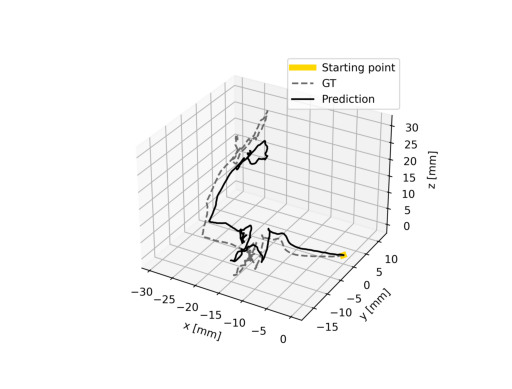

In [4]:
import matplotlib.pyplot as plt
from PIL import Image

img  = Image.open('vo_sq2_19.png')
plt.axis('OFF')
plt.imshow(img)

Depth for a sample frame:

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Text(0.5, 1.0, 'Depth Prediction')

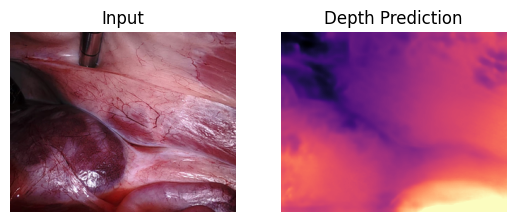

In [6]:
import datasets
from torch.utils.data import DataLoader
import torch
import numpy as np
import matplotlib.pyplot as plt

import networks
from layers import disp_to_depth


scared_dataset = datasets.SCAREDRAWDataset
with open("splits/endovis/test_files_sequence2.txt", 'r') as f:
    filenames = f.read().splitlines()

img_ext = '.jpg'
data_path = ""
height = 256
width = 320
frame_ids = [-2, -1, 0, 1, 2]
num_samples = len(filenames)

sample_dataset = scared_dataset(data_path, filenames, height, width,
    frame_ids, 4, is_train=False, img_ext=img_ext)
loader = DataLoader(
    sample_dataset, 8, True, pin_memory=True, drop_last=True)

inputs = next(enumerate(loader))
sample = inputs[1][("color_aug", -2, 0)]

device = "cuda" if torch.cuda.is_available() else "cpu"

encoder_path = "weights_19/encoder.pth"
decoder_path = "weights_19/depth.pth"
encoder_dict = torch.load(encoder_path, map_location=device)
encoder = networks.ResnetEncoder(18, False)
depth_decoder = networks.DepthDecoder(encoder.num_ch_enc, scales=range(4))

model_dict = encoder.state_dict()
encoder.load_state_dict({k: v for k, v in encoder_dict.items() if k in model_dict})
depth_decoder.load_state_dict(torch.load(decoder_path, map_location=device))

encoder.to(device)
encoder.eval()
depth_decoder.to(device)
depth_decoder.eval()
sample = sample.to(device)

output = depth_decoder(encoder(sample))
pred_disp_resized, _ = disp_to_depth(output[("disp", 0)], 1e-3, 150)
pred_disp_tensor = pred_disp_resized.cpu()[:, 0].detach()
pred_disp = pred_disp_resized.cpu()[:, 0].detach().numpy()
sample = sample.cpu()
vmax = np.percentile(pred_disp, 95)

plt.subplot(121), plt.imshow(sample[0].permute(1,2,0))
plt.axis('OFF')
plt.title('Input')

plt.subplot(122), plt.imshow(pred_disp[0], cmap='magma', vmax=vmax)
plt.axis('OFF')
plt.title('Depth Prediction')

Save depth prediction as "depth.jpeg":

In [23]:
import matplotlib as mpl
import matplotlib.cm as cm
import cv2
from PIL import Image

disp = output[("disp", 0)]
disp_resized = torch.nn.functional.interpolate(
    disp, (1024, 1280), mode="bilinear", align_corners=False)
disp_resized_np = disp_resized.squeeze().detach().cpu().numpy()
vmax = np.percentile(disp_resized_np, 95)
normalizer = mpl.colors.Normalize(vmin=disp_resized_np.min(), vmax=vmax)
mapper = cm.ScalarMappable(norm=normalizer, cmap='magma')
# print(disp_resized_np[0].shape)
colormapped_im = (mapper.to_rgba(disp_resized_np[0])[:, :, :3] * 255).astype(np.uint8)
im = Image.fromarray(colormapped_im)
im.save("depth.jpeg", quality=95)

(1024, 1280)


3D Reconstruction for a sample frame from predicted depth and pose and GT depth and pose:

In [ ]:
import numpy as np
from PIL import Image
from torchvision import transforms
from layers import generate_pointcloud_ply

# load depth
pred_path = "/content/Long-Term_Reprojection_Loss/depth.jpeg"
d = cv2.imread(pred_path, 6)[:1024,:,0]
# print(d.shape, d.min(), d.max()) #(1024, 1280) 0.0 184.40317
depth = torch.tensor(d, dtype=torch.float32)# [1024,1280]
# load input
img_path = "/content/Long-Term_Reprojection_Loss/02/d3k4/000000.jpg" # "/content/frames/d3/000001.jpg"
img = Image.open(img_path)
img = np.array(img)
# print(img.shape) # (1024, 1280, 3)

# intrinsics
h, w,fx, fy, cx, cy = 1024, 1280, 1035.30811, 1035.08765, 595.955017, 520.410034
intrinsics = [
    [fx, 0., cx, 0.], [0., fy, cy, 0.],
    [0., 0., 1., 0.], [0., 0., 0., 1.]
]

meshgrid = np.meshgrid(range(w), range(h), indexing='xy') #ndarray with shape (1024, 1280),
id_coords = np.stack(meshgrid, axis=0).astype(np.float32)
id_coords = depth.new_tensor(id_coords)# [2, 1024, 1280]
pix_coords = torch.cat([id_coords[0].view(-1).unsqueeze(dim=0), id_coords[1].view(-1).unsqueeze(dim=0)], 0)
ones = torch.ones(1, w * h)
pix_coords = torch.cat([pix_coords, ones], dim=0) # 3xHW
inv_K = np.array(np.matrix(intrinsics).I)
inv_K = pix_coords.new_tensor(inv_K)
cam_points = torch.matmul(inv_K[:3, :3], pix_coords)
depth_flatten = depth.view(-1)
cam_points = torch.einsum('cn,n->cn', cam_points, depth_flatten)#[3, 1310720]
img_tensor = torch.tensor(img, dtype=torch.uint8)
img_tensor_flatten = img_tensor.permute(2, 0, 1).flatten(start_dim=1)# [3, 219520]
generate_pointcloud_ply(cam_points, img_tensor_flatten.numpy(), 'surface.ply')

Save surface reconstruction as "surface.ply":

In [ ]:
from google.colab import files
files.download('surface.ply')

Depth Metrics as paper:

To evaluate on availble images downloaded in colab, please modify the "evaluate_depth.py" line 78, changing from ""test_files.txt"" to "test_files_sequence2.txt". If colab is out of RAM, please modify "test_files_sequence2.txt" to 100-200 amount of file names.

In [12]:
%cd /content/Long-Term_Reprojection_Loss
!python evaluate_depth.py --load_weights_folder weights_19 --eval_mono --eval_split endovis --data_path '' --max_depth 150.0 --batch_size 4

/content/Long-Term_Reprojection_Loss
-> Loading weights from weights_19
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
total samples:  101
batch size:  4
number of batch / epoch:  7
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weigh